EOF
Top-148,Sketch:8*512
Execution time:  18.804 seconds.
Top_list with 18616 bytes.
Sketch with 16960 bytes.
Total size 34.7421875 kbytes, 
Find:92
Top_ARE: 2.8563
Top_AAE: 1167.5109
Estimate time:  0.967 seconds.

For copy:
Execution time:  18.804 seconds.
Top-148,CMS:8*512
Top_list with 18616 bytes.
Sketch with 16960 bytes.
Total size 34.7421875 kbytes, 
Find 0.622 of Heavy Hitters
Top_ARE: 2.8563
Top_AAE: 1167.5109
Estimate time:  0.967 seconds.
seed:[2431002307, 2298604811, 3001310189, 4054367153, 3077107013, 2263670957, 2673971459, 3053611343]


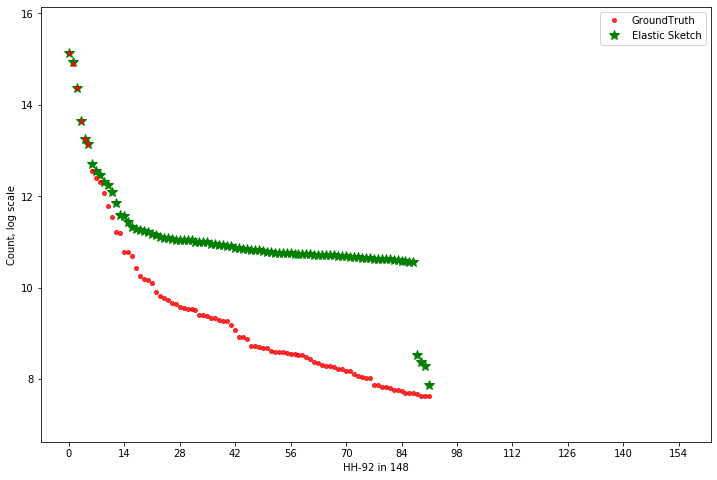

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [14]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=512
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*2048
Execution time:  26.199 seconds.
Top_list with 19832 bytes.
Sketch with 66112 bytes.
Total size 83.9296875 kbytes, 
Find:92
Top_ARE: 0.5853
Top_AAE: 271.3804
Estimate time:  0.816 seconds.

For copy:
Execution time:  26.199 seconds.
Top-148,CMS:8*2048
Top_list with 19832 bytes.
Sketch with 66112 bytes.
Total size 83.9296875 kbytes, 
Find 0.622 of Heavy Hitters
Top_ARE: 0.5853
Top_AAE: 271.3804
Estimate time:  0.816 seconds.
seed:[4024507511, 3920917717, 2665937867, 2296103651, 3154864997, 3290511899, 3807067679, 3987381481]


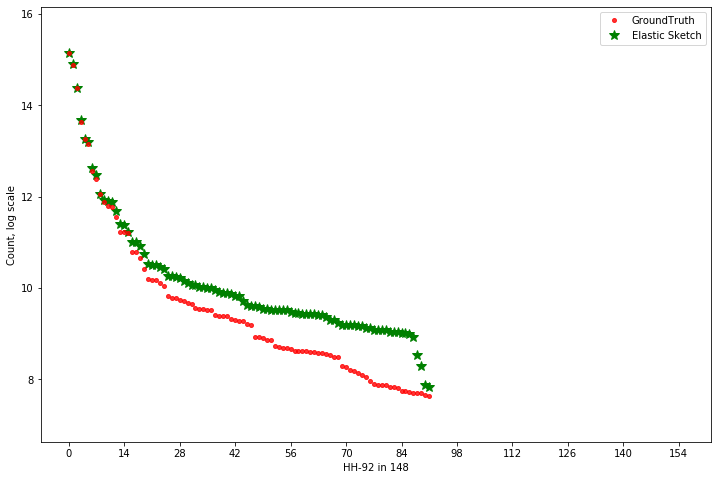

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [15]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=2048
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
Top-148,Sketch:8*5500
Execution time:  20.145 seconds.
Top_list with 20520 bytes.
Sketch with 176576 bytes.
Total size 192.4765625 kbytes, 
Find:87
Top_ARE: 0.1961
Top_AAE: 83.4138
Estimate time:  0.885 seconds.

For copy:
Execution time:  20.145 seconds.
Top-99,CMS:8*5500
Top_list with 20520 bytes.
Sketch with 176576 bytes.
Total size 192.4765625 kbytes, 
Find 0.588 of Heavy Hitters
Top_ARE: 0.1961
Top_AAE: 83.4138
Estimate time:  0.885 seconds.
seed:[3817248769, 2982429209, 2347892341, 2187321727, 2694275231, 2808907097, 3564370477, 2536720129]


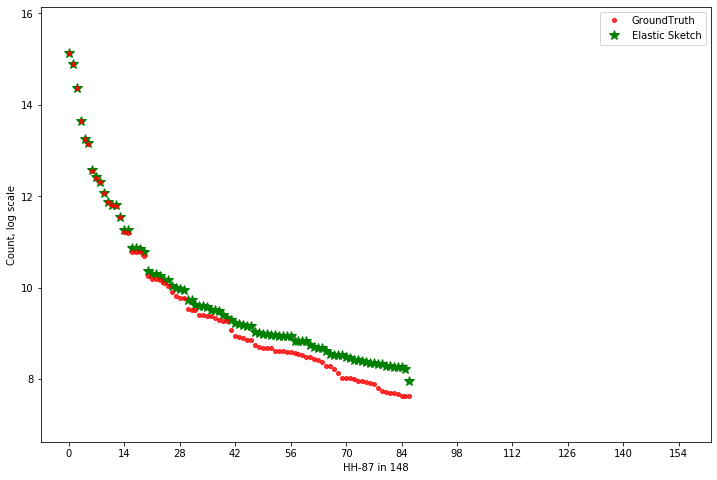

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [19]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=5500
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*8900
Execution time:  25.806 seconds.
Top_list with 18992 bytes.
Sketch with 285376 bytes.
Total size 297.234375 kbytes, 
Find:93
Top_ARE: 0.1280
Top_AAE: 52.1290
Estimate time:  1.071 seconds.

For copy:
Execution time:  25.806 seconds.
Top-107,CMS:8*8900
Top_list with 18992 bytes.
Sketch with 285376 bytes.
Total size 297.234375 kbytes, 
Find 0.628 of Heavy Hitters
Top_ARE: 0.1280
Top_AAE: 52.1290
Estimate time:  1.071 seconds.
seed:[4025842703, 2729748323, 2260812251, 2334553433, 3558555307, 4069908877, 3871075141, 2380897699]


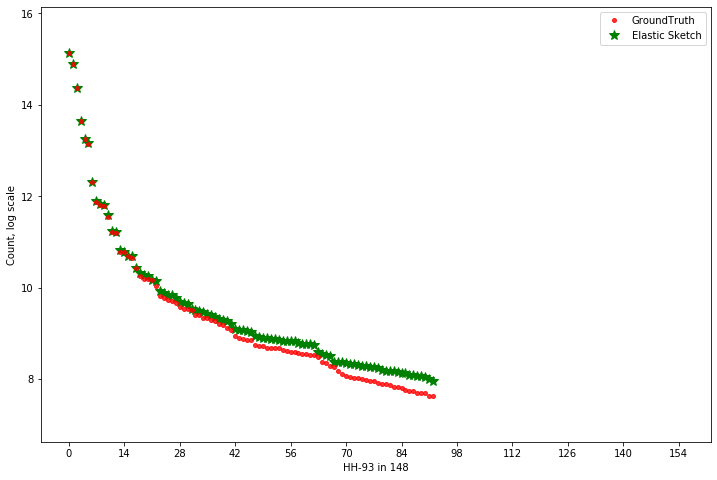

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [20]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=8900
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*12300
Execution time:  24.244 seconds.
Top_list with 19336 bytes.
Sketch with 394176 bytes.
Total size 403.8203125 kbytes, 
Find:90
Top_ARE: 0.0864
Top_AAE: 36.1111
Estimate time:  0.800 seconds.

For copy:
Execution time:  24.244 seconds.
Top-99,CMS:8*12300
Top_list with 19336 bytes.
Sketch with 394176 bytes.
Total size 403.8203125 kbytes, 
Find 0.608 of Heavy Hitters
Top_ARE: 0.0864
Top_AAE: 36.1111
Estimate time:  0.800 seconds.
seed:[2951191591, 3788298401, 2797295681, 2461484911, 3000322733, 4052270227, 3360341693, 3676979849]


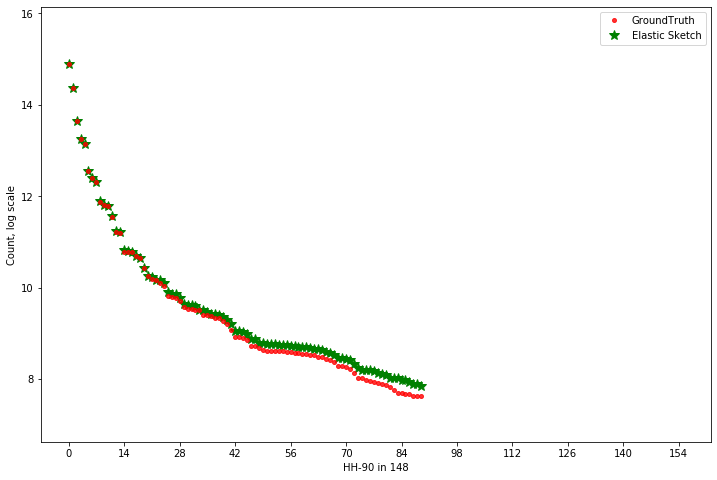

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [16]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=12300
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*15700
Execution time:  19.534 seconds.
Top_list with 18872 bytes.
Sketch with 502976 bytes.
Total size 509.6171875 kbytes, 
Find:90
Top_ARE: 0.0598
Top_AAE: 26.1667
Estimate time:  0.765 seconds.

For copy:
Execution time:  19.534 seconds.
Top-98,CMS:8*15700
Top_list with 18872 bytes.
Sketch with 502976 bytes.
Total size 509.6171875 kbytes, 
Find 0.608 of Heavy Hitters
Top_ARE: 0.0598
Top_AAE: 26.1667
Estimate time:  0.765 seconds.
seed:[4127989577, 2959590493, 3116109889, 4041850171, 2568253729, 3477023531, 4216745587, 2936235191]


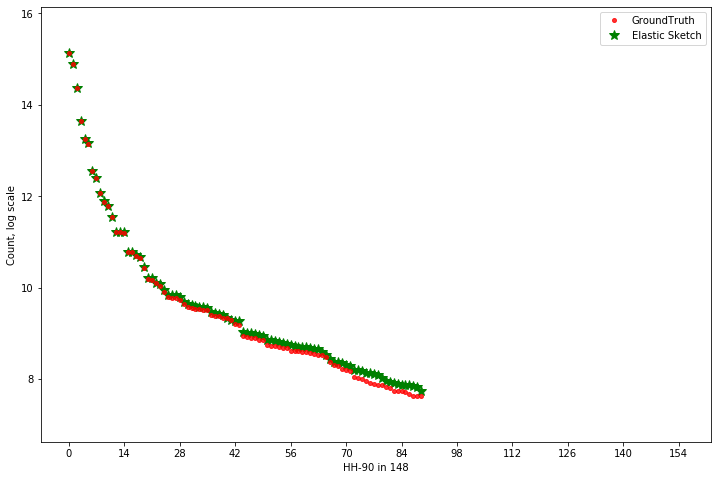

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [13]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=15700
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*19100
Execution time:  22.106 seconds.
Top_list with 19080 bytes.
Sketch with 611776 bytes.
Total size 616.0703125 kbytes, 
Find:93
Top_ARE: 0.0477
Top_AAE: 20.0430
Estimate time:  0.900 seconds.

For copy:
Execution time:  22.106 seconds.
Top-97,CMS:8*19100
Top_list with 19080 bytes.
Sketch with 611776 bytes.
Total size 616.0703125 kbytes, 
Find 0.628 of Heavy Hitters
Top_ARE: 0.0477
Top_AAE: 20.0430
Estimate time:  0.900 seconds.
seed:[2318148643, 3434629501, 2558626453, 4060001051, 2969402041, 4276356127, 3743769919, 3391149871]


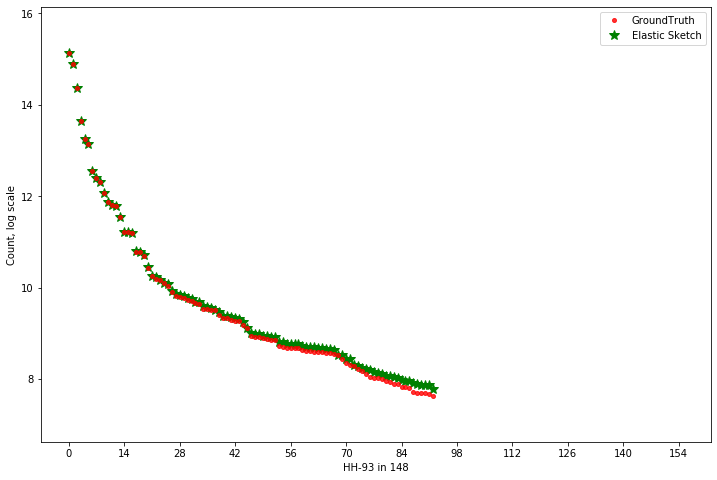

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [21]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=19100
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*22500
Execution time:  21.596 seconds.
Top_list with 20912 bytes.
Sketch with 720576 bytes.
Total size 724.109375 kbytes, 
Find:98
Top_ARE: 0.0435
Top_AAE: 18.1429
Estimate time:  0.873 seconds.

For copy:
Execution time:  21.596 seconds.
Top-104,CMS:8*22500
Top_list with 20912 bytes.
Sketch with 720576 bytes.
Total size 724.109375 kbytes, 
Find 0.662 of Heavy Hitters
Top_ARE: 0.0435
Top_AAE: 18.1429
Estimate time:  0.873 seconds.
seed:[2289845347, 2280430501, 3525576253, 3190347697, 3714769901, 3363978593, 4057876103, 3240612901]


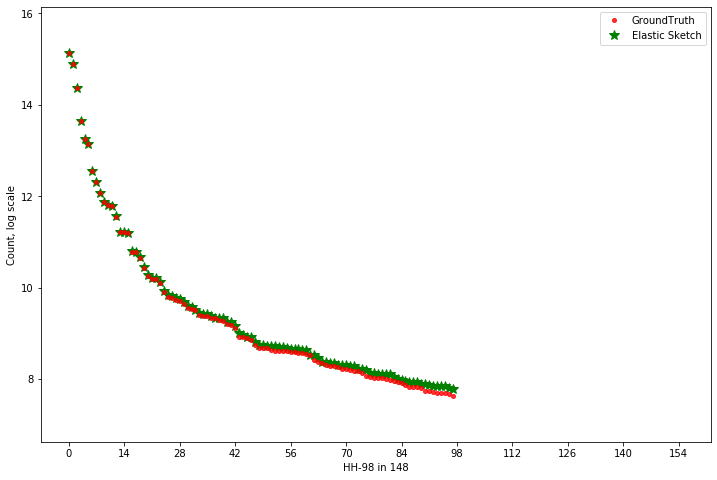

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [22]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=22500
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*25900
Execution time:  21.153 seconds.
Top_list with 19512 bytes.
Sketch with 829376 bytes.
Total size 828.9921875 kbytes, 
Find:96
Top_ARE: 0.0355
Top_AAE: 14.6042
Estimate time:  1.120 seconds.

For copy:
Execution time:  21.153 seconds.
Top-103,CMS:8*25900
Top_list with 19512 bytes.
Sketch with 829376 bytes.
Total size 828.9921875 kbytes, 
Find 0.649 of Heavy Hitters
Top_ARE: 0.0355
Top_AAE: 14.6042
Estimate time:  1.120 seconds.
seed:[2193194459, 4101958277, 2435012669, 3647135377, 2689954573, 2417886271, 3276106121, 2542773253]


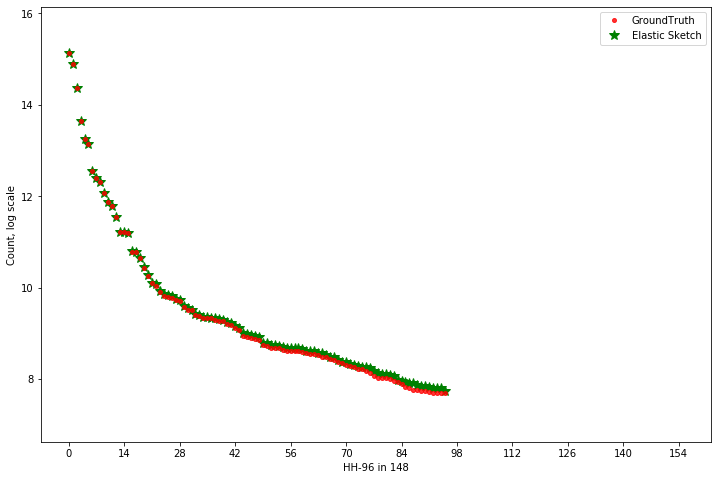

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [23]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=25900
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*29300
Execution time:  24.485 seconds.
Top_list with 18976 bytes.
Sketch with 938176 bytes.
Total size 934.71875 kbytes, 
Find:97
Top_ARE: 0.0300
Top_AAE: 12.8763
Estimate time:  1.156 seconds.

For copy:
Execution time:  24.485 seconds.
Top-101,CMS:8*29300
Top_list with 18976 bytes.
Sketch with 938176 bytes.
Total size 934.71875 kbytes, 
Find 0.655 of Heavy Hitters
Top_ARE: 0.0300
Top_AAE: 12.8763
Estimate time:  1.156 seconds.
seed:[4215691951, 3843036823, 2916009403, 3388677139, 2675631019, 4243665541, 2648636371, 3837245509]


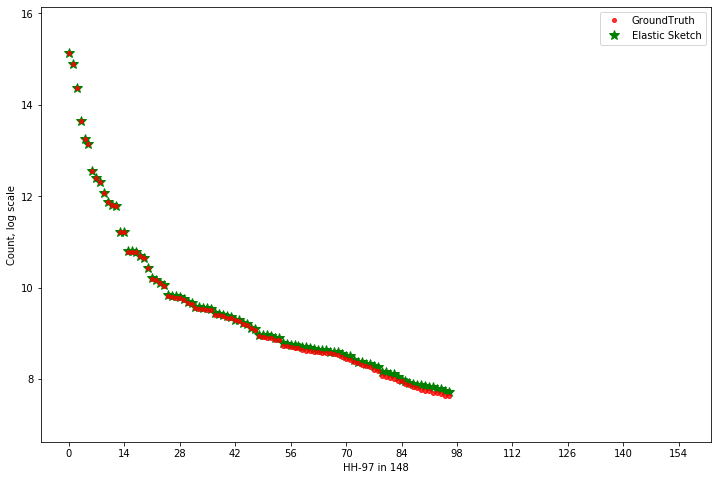

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [24]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=29300
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''



EOF
Top-148,Sketch:8*32700
Execution time:  23.852 seconds.
Top_list with 19216 bytes.
Sketch with 1046976 bytes.
Total size 1041.203125 kbytes, 
Find:92
Top_ARE: 0.0283
Top_AAE: 11.7717
Estimate time:  0.859 seconds.

For copy:
Execution time:  23.852 seconds.
Top-94,CMS:8*32700
Top_list with 19216 bytes.
Sketch with 1046976 bytes.
Total size 1041.203125 kbytes, 
Find 0.622 of Heavy Hitters
Top_ARE: 0.0283
Top_AAE: 11.7717
Estimate time:  0.859 seconds.
seed:[3020447231, 2797909421, 3925328117, 4098343037, 3521884159, 2469631289, 2560565783, 2773233653]


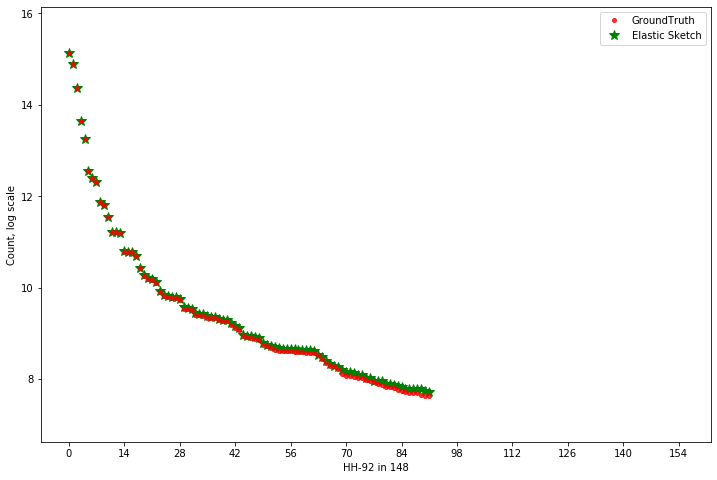

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [25]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=32
w=32700
d=8
size=148
topk=148
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size


# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''

